In [1]:
import numpy as np
import matplotlib.pyplot as plt
from pprint import pprint
from scipy import signal
from scipy.signal import correlate

In [2]:
# dark theme
plt.style.use('dark_background')

# customize the style
plt.rcParams.update({
    'figure.facecolor': '#131416',
    'axes.facecolor': '#131416',
    'axes.edgecolor': 'white',
    'axes.labelcolor': 'white',
    'xtick.color': 'white',
    'ytick.color': 'white',
    'text.color': 'white',
    'axes.prop_cycle': plt.cycler(color=plt.cm.tab10.colors),  # use standard matplotlib colors
})

In [3]:
import neuron
from neuron import h

In [4]:
import os
home = os.path.expanduser("~")
model_name = 'Park_2019'
path_to_model = os.path.join(home, 'Documents', 'code', 'DendroTweaksLab', 'DendroTweaks', 'examples', model_name)
path_to_data = os.path.dirname(path_to_model)

In [5]:
import sys
sys.path.append(path_to_model)
from Park_2019_NEURON import Cell, run, load_mechanisms

In [6]:
morpho = os.path.join(path_to_model, 'morphology', 'Park_2019_sorted.swc')
mod = os.path.join(path_to_model, 'membrane', 'temp_mod')

In [ ]:
load_mechanisms(mod);

In [8]:
cell = Cell(morpho)

In [9]:
# h.topology()

In [9]:
len(cell.all_segments)

246

In [10]:
rec = h.Vector()
rec.record(cell.soma[0](0.5)._ref_v)

Vector[0]

In [11]:
iclamps = cell.add_iclamps()

In [12]:
t = h.Vector().record(h._ref_t)
run(1000, temperature=37, v_init=-79)
v = rec.to_python()
t = t.to_python()
v_nrn = np.array(v)

In [13]:
path_to_voltage = os.path.join(path_to_model, 'voltage.npy')
v_dd = np.load(path_to_voltage)

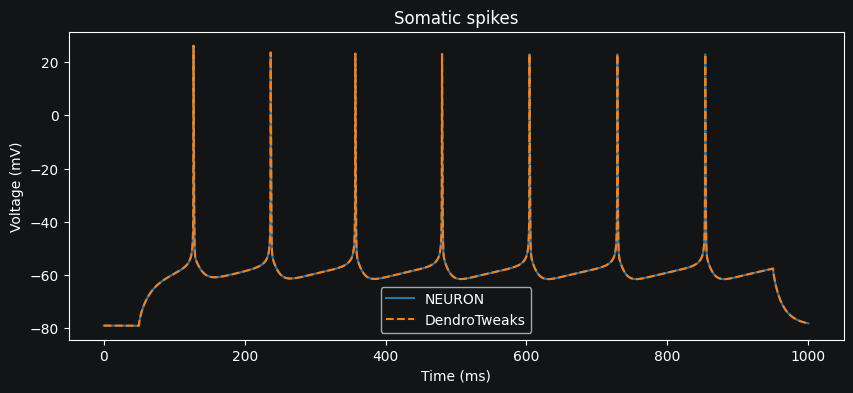

In [14]:
fig, ax = plt.subplots(1, 1, figsize=(10, 4))
ax.plot(t, v_nrn, label='NEURON')
ax.plot(t, v_dd, '--', color='C1', label='DendroTweaks')
ax.set_xlabel('Time (ms)')
ax.set_ylabel('Voltage (mV)')
plt.title('Somatic spikes')
plt.legend()

Text(0.5, 1.0, 'Difference in somatic spikes')

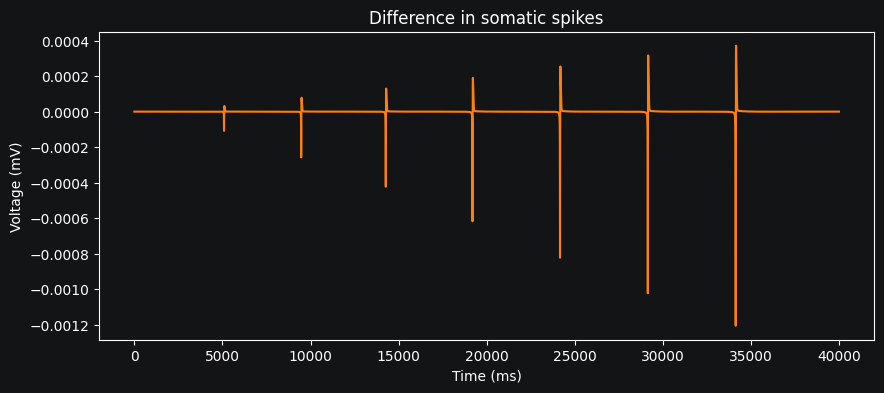

In [16]:
fig, ax = plt.subplots(1, 1, figsize=(10, 4))
ax.plot(v_dd - v_nrn, color='C1', label='DendroTweaks - NEURON')
ax.set_xlabel('Time (ms)')
ax.set_ylabel('Voltage (mV)')
plt.title('Difference in somatic spikes')

In [19]:
# Compute the cross-correlation of the two signals
correlation = np.corrcoef(v_dd, v_nrn)[0,1]
print(f'Correlation: {correlation}')

Correlation: 0.9999999999938197


In [20]:
# Detect spike times in both signals
from scipy import signal

threshold = -20  # mV, adjust based on your AP threshold

# Find spike times
spikes_dd = signal.find_peaks(v_dd, height=threshold)[0]
spikes_nrn = signal.find_peaks(v_nrn, height=threshold)[0]

# Convert to time in ms (assuming your x-axis units)
time_array = np.linspace(0, 1000, len(v_dd))  # Adjust based on your time range
spike_times_dd = time_array[spikes_dd]
spike_times_nrn = time_array[spikes_nrn]

# Calculate average timing difference between corresponding spikes
timing_diffs = np.abs(spike_times_dd - spike_times_nrn)
avg_timing_diff = np.mean(timing_diffs)
print(f"Average spike timing difference: {avg_timing_diff:.3f} ms")

Average spike timing difference: 0.000 ms


In [21]:
# Function to get AP features
def get_ap_features(v, time_array, spike_indices):
    features = {}
    features['count'] = len(spike_indices)
    if len(spike_indices) > 0:
        # Mean/std firing rate from interspike intervals
        if len(spike_indices) > 1:
            isis = np.diff(time_array[spike_indices])
            features['mean_rate'] = 1000/np.mean(isis)  # Hz
            features['cv_isi'] = np.std(isis)/np.mean(isis)  # Coefficient of variation
        
        # AP amplitude
        resting = np.mean(v[v < threshold - 10])
        features['ap_amp'] = np.mean(v[spike_indices] - resting)
        
        # AP width (approximate)
        # More complex implementation needed for actual half-width
        
    return features

# Compare features
dd_features = get_ap_features(v_dd, time_array, spikes_dd)
nrn_features = get_ap_features(v_nrn, time_array, spikes_nrn)

for key in dd_features:
    print(f"{key}: {dd_features[key]:.3f} vs {nrn_features[key]:.3f}")

count: 7.000 vs 7.000
mean_rate: 8.261 vs 8.261
cv_isi: 0.044 vs 0.044
ap_amp: 84.095 vs 84.095


In [22]:
path_to_diams = os.path.join(path_to_model, 'diams.npy')
diam_dd = np.load(path_to_diams)
diam_nrn = np.array([seg.diam for seg in cell.all_segments])

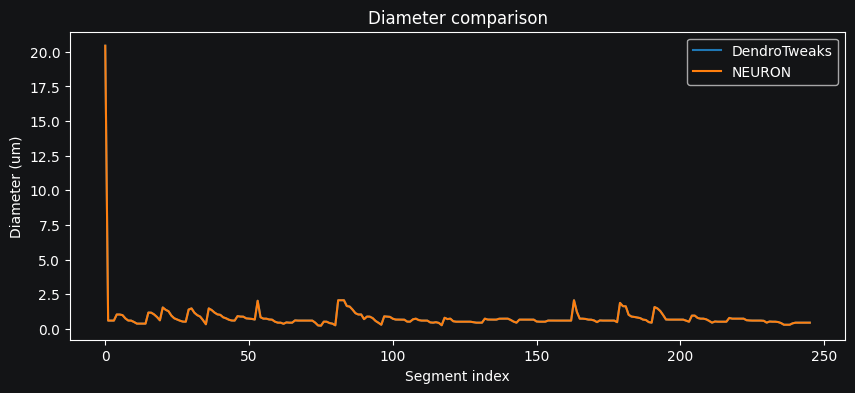

In [29]:
fig, ax = plt.subplots(1, 1, figsize=(10, 4))
ax.plot(diam_dd, label='DendroTweaks')
ax.plot(diam_nrn, label='NEURON')
ax.set_xlabel('Segment index')
ax.set_ylabel('Diameter (um)')
ax.legend()
ax.set_title('Diameter comparison');

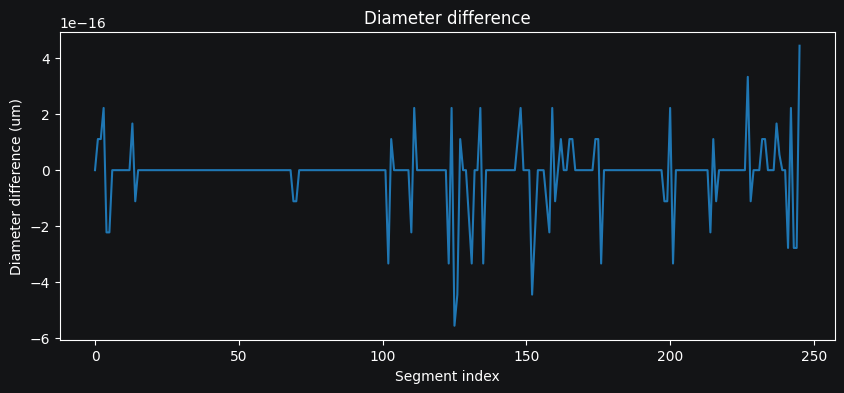

In [31]:
fig, ax = plt.subplots(1, 1, figsize=(10, 4))
ax.plot(diam_dd - diam_nrn)
ax.set_xlabel('Segment index')
ax.set_ylabel('Diameter difference (um)')
ax.set_title('Diameter difference');

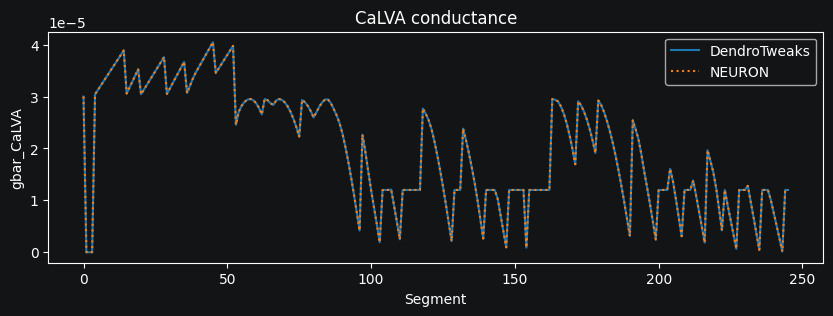

In [32]:
path_to_calva = os.path.join(path_to_model, 'calva.npy')
calva_dd = np.load(path_to_calva)
calva_nrn = np.array([getattr(seg, 'gbar_CaLVA', 0) for seg in cell.all_segments])

fig, ax = plt.subplots(1, 1, figsize=(10, 3))

ax.plot(calva_dd, label='DendroTweaks')
ax.plot(calva_nrn, ':', label='NEURON')
ax.set_xlabel('Segment')
ax.set_ylabel('gbar_CaLVA')
ax.set_title('CaLVA conductance')
ax.legend();